# Настройка среды

In [1]:
import os
import sys

### Yandex Datasphere
sys.path.append(os.path.abspath(".."))

### Google Colab
# !git clone https://github.com/Belashov641618/OpticalEncoder.git
# sys.path.append(os.path.abspath("OpticalEncoder"))

In [2]:
# %cd OpticalEncoder
# !dir
# !git pull

In [3]:
# %pip install belashovplot
# %pip install optuna
# %pip install timm

In [4]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from utilities.training import train, confusion
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
from pickle import dump
import torch
import numpy
import optuna
import timm
import pickle

C:\Users\uclap\Documents\Coding\Python\OpticalEncoder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FigureWidthHeight = (16, 16)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA GeForce RTX 3060 Ti


# Оптимизиция при оптимальной дистанции распространения

## Установка не изменяемых параметров

In [7]:
# Предпочтительные параметры
size = 50.0E-6
near_N = 300
near_length = 5.0E-3
wavelength = 500.0E-9
optuna_epochs = 1

# Параметры когерентности
spatial_coherence = 50.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 7

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size

cppp = upper_integer(near_N * size / length)
N = int(length / size) * cppp

reference_distance = length * sqrt((size/wavelength)**2 - 1)

## Инициализация некогерентной обёртки

In [8]:
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length).to(device)

In [9]:
autocorr = autocorrelation(incoherent.sample(), dims=[1,2], mean_dim=0, split=mean_samples)

In [10]:
autocorr_radius, _ = correlation_circle(autocorr, limits=((-length/2,+length/2),(-length/2,+length/2)), percent=0.8)
incoherent_distribution, incoherent_distribution_values = distribution(incoherent.sample(), N=100, return_values=True)
incoherent_sample = incoherent.sample()[0].cpu()
print('Радиус автокорреляции:', engineering(autocorr_radius, 'м'))

Радиус автокорреляции: 16.722 мкм


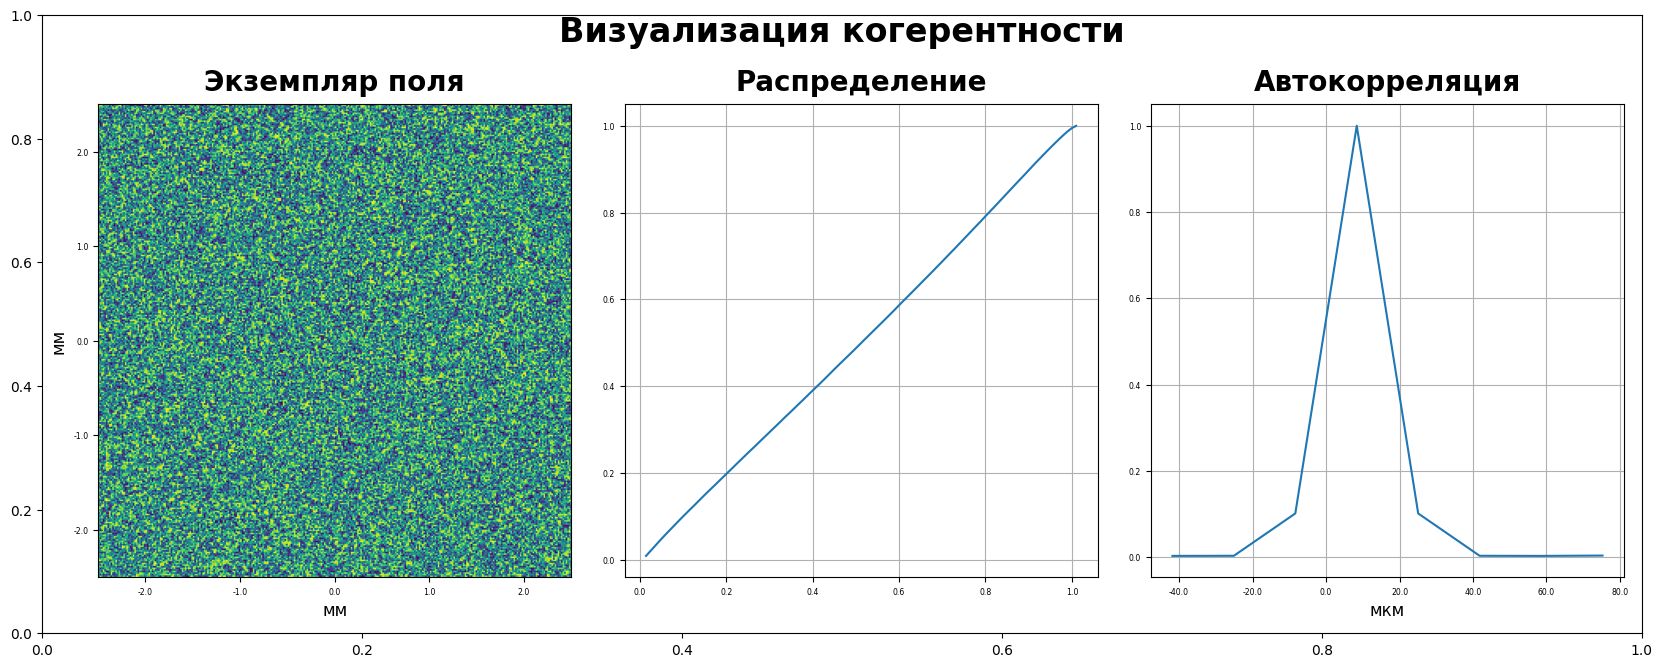

In [11]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Визуализация когерентности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')
formatter_rad, unit_rad = engineering.separatedformatter(autocorr_radius, 'м')

axes = plot.axes.add(0,0)
axes.imshow(incoherent_sample, aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)
plot.graph.title('Экземпляр поля')

axes = plot.axes.add(1,0)
axes.grid(True)
axes.plot(incoherent_distribution_values, incoherent_distribution.cpu())
plot.graph.title('Распределение')

p0 = int(autocorr.shape[1]*(1 - 4*autocorr_radius/length)/2)
p1 = p0 + int(8*autocorr.shape[1]*autocorr_radius/length)
axes = plot.axes.add(2,0)
axes.grid(True)
axes.plot(numpy.linspace(-length/2, +length/2, autocorr.shape[1])[p0:p1], autocorr[autocorr.shape[0]//2][p0:p1]/autocorr.max())
axes.xaxis.set_major_formatter(formatter_rad)
plot.graph.label.x(unit_rad)
plot.graph.title('Автокорреляция')

plot.show()

## Инициализация детекторов

In [12]:
detectors_amount = 24
detector_size = length / 60

spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((detector_size, detector_size), (0,0))
detectors = MatrixDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter).to(device)

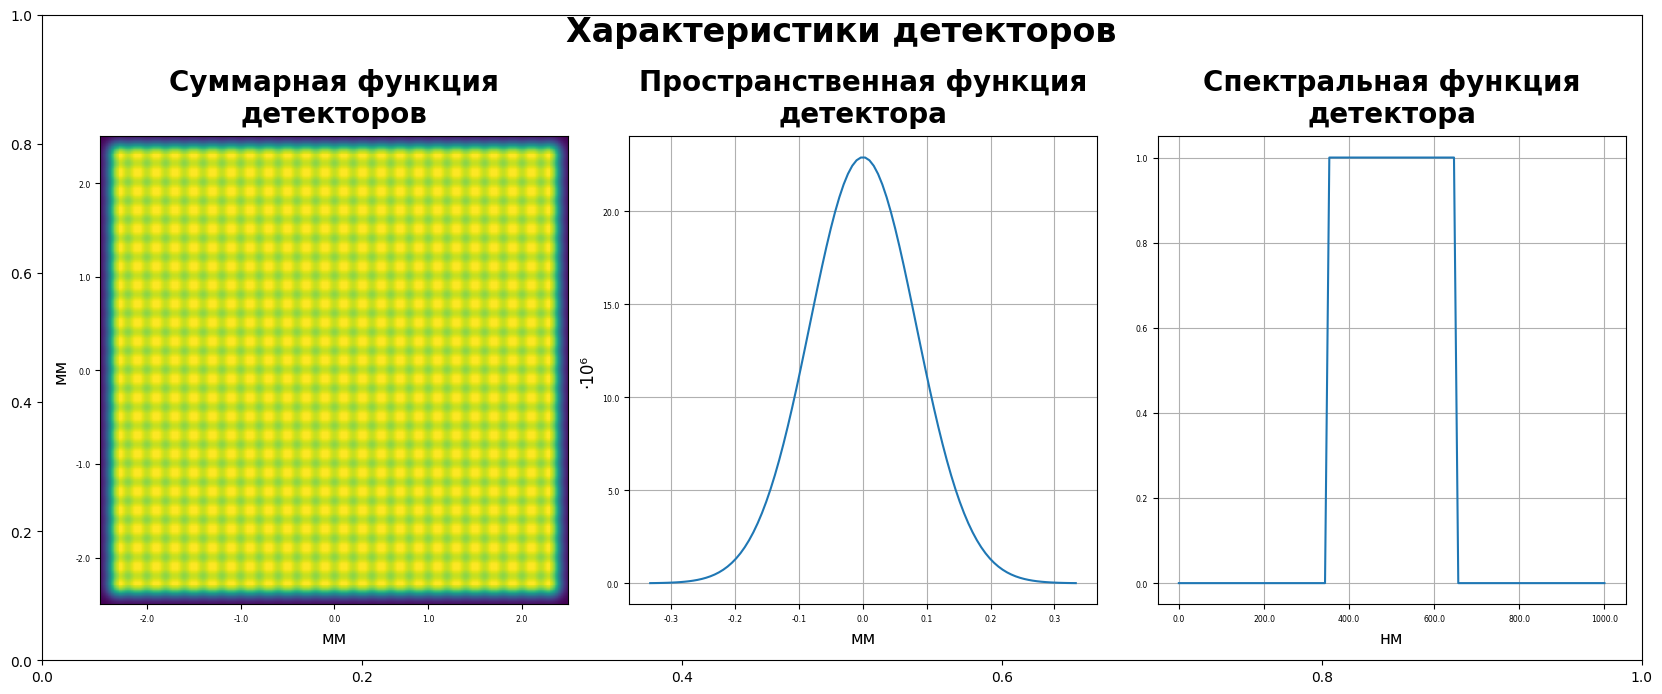

In [13]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.pad.graph.horizontal(0.1)
plot.title('Характеристики детекторов')

x_linspace = torch.linspace(-4*detector_size,+4*detector_size,100)
y_linspace = detectors_filter(x_linspace, x_linspace)[50]
wl_linspace = torch.linspace(0, 1000.0E-9, 100)
s_linspace = spectral_filter(wl_linspace)
formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')
formatter_d, unit_d = scientific.separatedformatter(y_linspace.max(), '')
formatter_wl, unit_wl = engineering.separatedformatter(wl_linspace.max(), 'м')

axes = plot.axes.add(0,0)
axes.imshow(detectors.filter, aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)
plot.graph.title('Суммарная функция детекторов')

axes = plot.axes.add(1,0)
axes.grid(True)
axes.plot(x_linspace, y_linspace)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_d)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_d)
plot.graph.title('Пространственная функция детектора')

axes = plot.axes.add(2,0)
axes.grid(True)
axes.plot(wl_linspace, s_linspace)
axes.xaxis.set_major_formatter(formatter_wl)
plot.graph.label.x(unit_wl)
plot.graph.title('Спектральная функция детектора')

plot.show()

## Инициализация электронной части

In [14]:
electronic = timm.create_model('resnet18', pretrained=True,  in_chans=1, num_classes=10).to(device)

## Комбинированная функция 

In [15]:
def combined_loss(cross_entropy_to_mse_proportion:float=1.0):
    def loss_function(outputs, targets):
        CELoss = torch.nn.functional.cross_entropy(outputs, targets)
        MSELoss = torch.nn.functional.mse_loss(torch.nn.functional.softmax(outputs, dim=1), torch.nn.functional.one_hot(targets, num_classes=10).float())
        loss = cross_entropy_to_mse_proportion*CELoss + (1.0-cross_entropy_to_mse_proportion)*MSELoss
        return loss
    return loss_function

## Выбор диапазона раcстояния распространения

In [16]:
# Настройка диапазона
distance_left_multiplier = 0.05
distance_right_multiplier = 0.5

slices = 100
distance_samples = 4
distance_array = numpy.linspace(reference_distance*distance_left_multiplier, reference_distance*distance_right_multiplier, distance_samples)

In [17]:
different_distance_propagations = []
# Вычисления
initial = torch.zeros((1, 1, N, N), device=device, dtype=torch.complex64)
p0 = N//2 - int(N*size/(length*2))
p1 = p0 + int(N*size/length)
initial[0,0,p0:p1,p0:p1] = 1.0

chunker = CudaMemoryChunker().to(device) 
with torch.no_grad():
    for max_distance in tqdm(distance_array):
        result = torch.zeros((slices, N), dtype=torch.float32)
        for i, distance in enumerate(numpy.linspace(0, max_distance, slices)):
            propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance).to(device)
            chunker.attach_forward(propagation.forward)
            incoherent.attach_forward(chunker.forward)
            result[i] = incoherent.forward(initial)[0,0,N//2].abs().cpu()
        different_distance_propagations.append((max_distance, result))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.20s/it]


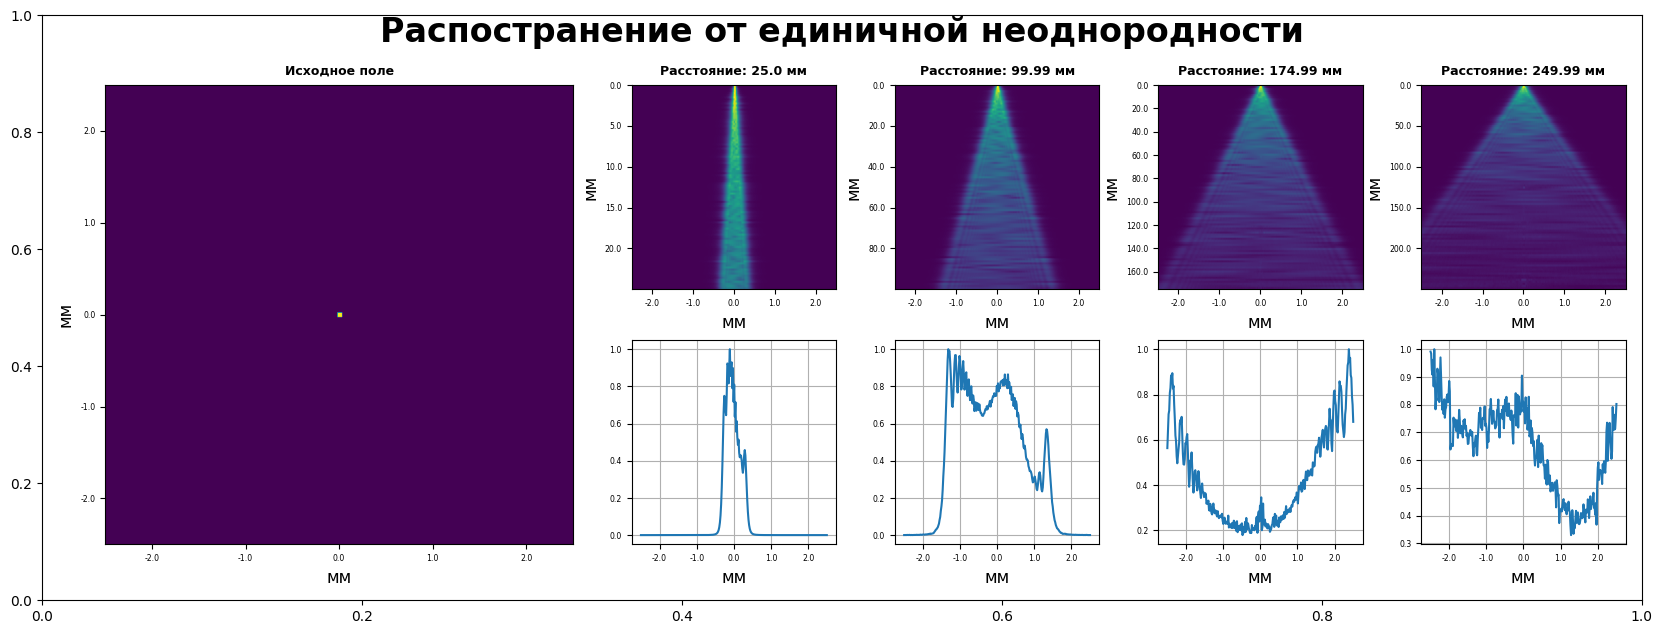

In [18]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Распостранение от единичной неоднородности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')

axes = plot.axes.add((0,0),(1,1))
axes.imshow(initial[0][0].abs().cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)

plot.description.column.top('Исходное поле',0,1)

for col, (distance, data) in enumerate(different_distance_propagations, 2):
    formatter_z, unit_z = engineering.separatedformatter(distance, 'м')
    plot.description.column.top(f"Расстояние: {engineering(distance,'м', 2)}", col)
    
    axes = plot.axes.add(col, 0)
    axes.imshow(torch.log10(data+0.0001), aspect='auto', extent=[-length/2,+length/2,distance,0])
    axes.xaxis.set_major_formatter(formatter_xy)
    axes.yaxis.set_major_formatter(formatter_z)
    plot.graph.label.x(unit_xy)
    plot.graph.label.y(unit_z)

    axes = plot.axes.add(col,1)
    axes.grid(True)
    axes.plot(numpy.linspace(-length/2,+length/2,N), data[-1]/data[-1].max())
    axes.xaxis.set_major_formatter(formatter_xy)
    plot.graph.label.x(unit_xy)

plot.show()

## Вариации изменяемых параметров

In [19]:
# Установить вручную по картинкам выше (чем больше покрытие и меньше шумов, тем лучше)
distance_limits = (80.0E-3, 180.0E-3)

In [20]:
masks_amount_limits = (3, 10)
batch_size_limits = (20, 40)
learning_rate_limits = (0.00001, 0.1)
loss_functions_proportion_limits = (0.0, 1.0)
optimizer_types_list = {'Adam':torch.optim.Adam, 'SGD':torch.optim.SGD, 'RMSprop':torch.optim.RMSprop, 'Adagrad':torch.optim.Adagrad}

## Вывод окончательных параметров

In [21]:
print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(size, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence, 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       300
Количество пикселей маски:                100
Размер оптических элементов:              5.0 мм
Размер пикселя маски:                     50.0 мкм
Расстояние между слоями:                  249.987 мм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           50.0 мкм
Количество усреднений:                    7


## Функция цели для optuna и оптимизация

In [22]:
def objective(trial:optuna.trial):
    masks_amount = trial.suggest_int('masks amount', *masks_amount_limits)
    batch_size = trial.suggest_int('batch size', *batch_size_limits)
    distance = trial.suggest_float('distance', *distance_limits)
    learning_rate = trial.suggest_float('learning rate', *learning_rate_limits, log=True)
    loss_functions_proportion = trial.suggest_float('cross entorpy proportion', *loss_functions_proportion_limits)
    optimizer_type = trial.suggest_categorical('optimizer type', optimizer_types_list.keys())

    print('Эксперимент:')
    print(f"\tКоличетсво масок:  {masks_amount}")
    print(f"\tРазмер батча:      {batch_size}")
    print(f"\tДистанция:         {engineering(distance, 'м')}")
    print(f"\tСкорость обучения: {learning_rate}")
    print(f"\tПропорция CELoss:  {loss_functions_proportion}")
    print(f"\tТип оптимизатора:  {optimizer_type}")
    
    # Инициализация оптической части и гибридной модели
    propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
    phase_modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
    amplitude_modulators = [AmplitudeModulator(N, length, pixels) for i in range(masks_amount)]
    elements = [phase_modulators[0], amplitude_modulators[0]]
    for phase_modulator, amplitude_modulator in zip(phase_modulators[1:], amplitude_modulators[1:]):
        elements.append(propagation)
        elements.append(phase_modulator)
        elements.append(amplitude_modulator)
    elements.append(propagation)
    chunker = CudaMemoryChunker(sub_chunks=mean_samples)
    optical = CompositeModel(*elements)
    optical.wrap(chunker)
    optical.wrap(incoherent)
    optical.to(device)
    model = HybridModel(optical, detectors, electronic)
    
    # Подготовка данных, функции ошибки и оптимизатора
    dataset = Dataset('CIFAR10', batch_size, N, N, torch.complex64)
    dataset.train
    dataset.test
    loss_function = combined_loss(loss_functions_proportion)
    optimizer = optimizer_types_list[optimizer_type](model.parameters(), lr=learning_rate)

    # Обучение модели
    for i in range(optuna_epochs):
        train(model, dataset, optimizer, loss_function)
    confusion_matrix = confusion(model, dataset)
    return 100*numpy.sum(numpy.diagonal(confusion_matrix, 0))/numpy.sum(confusion_matrix)
study = optuna.create_study(study_name="ID2NN", storage="sqlite:///ID2NN.db", direction='maximize', load_if_exists=True)

[I 2024-05-03 00:07:56,574] Using an existing study with name 'ID2NN' instead of creating a new one.


In [23]:
study.optimize(objective, n_trials=5)

Эксперимент:
	Количетсво масок:  6
	Размер батча:      35
	Дистанция:         80.91 мм
	Скорость обучения: 0.003155055940050313
	Пропорция CELoss:  0.9958284031279605
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.2429204251577888, RPI1000: -0.035845227280716895: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [10:35<00:00,  2.25it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [01:05<00:00,  4.39it/s]
[I 2024-05-03 00:19:39,927] Trial 114 finished with value: 14.41 and parameters: {'masks amount': 6, 'batch size': 35, 'distance': 0.08090950583137749, 'learning rate': 0.003155055940050313, 'cross entorpy proportion': 0.9958284031279605, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      36
	Дистанция:         80.3 мм
	Скорость обучения: 0.006141681474575413
	Пропорция CELoss:  0.8872969769331672
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8981730663250458, RPI1000: -0.10969463356833214: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [10:25<00:00,  2.22it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:05<00:00,  4.27it/s]
[I 2024-05-03 00:31:12,807] Trial 115 finished with value: 17.52 and parameters: {'masks amount': 6, 'batch size': 36, 'distance': 0.08029989793137074, 'learning rate': 0.006141681474575413, 'cross entorpy proportion': 0.8872969769331672, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      36
	Дистанция:         83.973 мм
	Скорость обучения: 0.007668567118160193
	Пропорция CELoss:  0.9369793543036196
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.0425981582718657, RPI1000: -0.10561636806219997: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [10:21<00:00,  2.23it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:03<00:00,  4.39it/s]
[I 2024-05-03 00:42:40,026] Trial 116 finished with value: 21.06 and parameters: {'masks amount': 6, 'batch size': 36, 'distance': 0.08397298161181405, 'learning rate': 0.007668567118160193, 'cross entorpy proportion': 0.9369793543036196, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  8
	Размер батча:      35
	Дистанция:         82.544 мм
	Скорость обучения: 0.012468193901982377
	Пропорция CELoss:  0.9692231429262428
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.10994890346794, RPI1000: -0.08540873579057501: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [12:55<00:00,  1.84it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [01:18<00:00,  3.63it/s]
[I 2024-05-03 00:56:56,129] Trial 117 finished with value: 19.24 and parameters: {'masks amount': 8, 'batch size': 35, 'distance': 0.082544371221149, 'learning rate': 0.012468193901982377, 'cross entorpy proportion': 0.9692231429262428, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      36
	Дистанция:         80.115 мм
	Скорость обучения: 0.0055830229574296356
	Пропорция CELoss:  0.8698282115253946
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.861561213958313, RPI1000: -0.03214913784984533: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [11:32<00:00,  2.01it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:11<00:00,  3.91it/s]
[I 2024-05-03 01:09:42,029] Trial 118 finished with value: 21.59 and parameters: {'masks amount': 7, 'batch size': 36, 'distance': 0.08011479325427764, 'learning rate': 0.0055830229574296356, 'cross entorpy proportion': 0.8698282115253946, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


In [24]:
study.optimize(objective, n_trials=5)

Эксперимент:
	Количетсво масок:  6
	Размер батча:      35
	Дистанция:         84.75 мм
	Скорость обучения: 0.00834823064843997
	Пропорция CELoss:  0.9436618312780707
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.029494382435339, RPI1000: -0.047617673511864606: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [10:12<00:00,  2.33it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [01:03<00:00,  4.52it/s]
[I 2024-05-03 01:21:00,320] Trial 119 finished with value: 21.79 and parameters: {'masks amount': 6, 'batch size': 35, 'distance': 0.08475031977280373, 'learning rate': 0.00834823064843997, 'cross entorpy proportion': 0.9436618312780707, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      34
	Дистанция:         82.13 мм
	Скорость обучения: 0.004480744222497179
	Пропорция CELoss:  0.9817876007451738
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.0564465064532484, RPI1000: -0.051959122359798215: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [11:44<00:00,  2.09it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [01:09<00:00,  4.25it/s]
[I 2024-05-03 01:33:56,310] Trial 120 finished with value: 23.1 and parameters: {'masks amount': 7, 'batch size': 34, 'distance': 0.0821301679457698, 'learning rate': 0.004480744222497179, 'cross entorpy proportion': 0.9817876007451738, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      37
	Дистанция:         84.862 мм
	Скорость обучения: 0.006906257303486775
	Пропорция CELoss:  0.9995318341270742
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.1021221967940535, RPI1000: -0.056343884607452474: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [10:22<00:00,  2.17it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [01:01<00:00,  4.38it/s]
[I 2024-05-03 01:45:22,391] Trial 121 finished with value: 20.21 and parameters: {'masks amount': 6, 'batch size': 37, 'distance': 0.08486230879646176, 'learning rate': 0.006906257303486775, 'cross entorpy proportion': 0.9995318341270742, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      37
	Дистанция:         90.279 мм
	Скорость обучения: 0.009064092973376112
	Пропорция CELoss:  0.8469116610212297
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7746901117455607, RPI1000: -0.04449050676730072: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [10:20<00:00,  2.18it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [01:02<00:00,  4.35it/s]
[I 2024-05-03 01:56:46,785] Trial 122 finished with value: 24.02 and parameters: {'masks amount': 6, 'batch size': 37, 'distance': 0.0902787419760646, 'learning rate': 0.009064092973376112, 'cross entorpy proportion': 0.8469116610212297, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      36
	Дистанция:         82.274 мм
	Скорость обучения: 0.012877623422143603
	Пропорция CELoss:  0.964550473391495
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.0069801149137305, RPI1000: -0.06078497649633768: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [11:42<00:00,  1.98it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:10<00:00,  3.95it/s]
[I 2024-05-03 02:09:41,847] Trial 123 finished with value: 20.85 and parameters: {'masks amount': 7, 'batch size': 36, 'distance': 0.08227422724171223, 'learning rate': 0.012877623422143603, 'cross entorpy proportion': 0.964550473391495, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


In [25]:
study.optimize(objective, n_trials=5)

Эксперимент:
	Количетсво масок:  8
	Размер батча:      36
	Дистанция:         86.791 мм
	Скорость обучения: 0.005144309989215856
	Пропорция CELoss:  0.9082109871791949
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8987100474541974, RPI1000: -0.06954926890261558: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [13:06<00:00,  1.77it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:18<00:00,  3.56it/s]
[I 2024-05-03 02:24:08,475] Trial 124 finished with value: 13.73 and parameters: {'masks amount': 8, 'batch size': 36, 'distance': 0.08679059781189469, 'learning rate': 0.005144309989215856, 'cross entorpy proportion': 0.9082109871791949, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      38
	Дистанция:         86.003 мм
	Скорость обучения: 0.009887242934280808
	Пропорция CELoss:  0.9271393779676063
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8717239386958673, RPI1000: -0.039963495423798234: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [10:20<00:00,  2.12it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:01<00:00,  4.28it/s]
[I 2024-05-03 02:35:32,866] Trial 125 finished with value: 22.06 and parameters: {'masks amount': 6, 'batch size': 38, 'distance': 0.08600337564700529, 'learning rate': 0.009887242934280808, 'cross entorpy proportion': 0.9271393779676063, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      37
	Дистанция:         83.775 мм
	Скорость обучения: 0.011364735023440646
	Пропорция CELoss:  0.9187326668904796
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.951829830058597, RPI1000: -0.06036637553802593: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [11:42<00:00,  1.92it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [01:09<00:00,  3.89it/s]
[I 2024-05-03 02:48:27,283] Trial 126 finished with value: 14.55 and parameters: {'masks amount': 7, 'batch size': 37, 'distance': 0.08377509308394725, 'learning rate': 0.011364735023440646, 'cross entorpy proportion': 0.9187326668904796, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         80.252 мм
	Скорость обучения: 0.013897718631072654
	Пропорция CELoss:  0.9491001459409065
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9106998004608857, RPI1000: -0.08367521306575779: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [08:59<00:00,  2.44it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:54<00:00,  4.82it/s]
[I 2024-05-03 02:58:23,214] Trial 127 finished with value: 26.8 and parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.08025241928462681, 'learning rate': 0.013897718631072654, 'cross entorpy proportion': 0.9491001459409065, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      35
	Дистанция:         80.057 мм
	Скорость обучения: 0.014014309611960532
	Пропорция CELoss:  0.9466160843560888
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.940964019707474, RPI1000: -0.06990109423424003: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [10:27<00:00,  2.28it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [01:01<00:00,  4.62it/s]
[I 2024-05-03 03:09:54,428] Trial 128 finished with value: 27.19 and parameters: {'masks amount': 6, 'batch size': 35, 'distance': 0.08005697090862475, 'learning rate': 0.014014309611960532, 'cross entorpy proportion': 0.9466160843560888, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


In [26]:
study.optimize(objective, n_trials=5)

Эксперимент:
	Количетсво масок:  6
	Размер батча:      35
	Дистанция:         80.015 мм
	Скорость обучения: 0.0072440937977607004
	Пропорция CELoss:  0.9524503155094257
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.0151647328870057, RPI1000: -0.0661006440433806: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [10:25<00:00,  2.28it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [01:02<00:00,  4.59it/s]
[I 2024-05-03 03:21:24,637] Trial 129 finished with value: 26.47 and parameters: {'masks amount': 6, 'batch size': 35, 'distance': 0.08001458133054085, 'learning rate': 0.0072440937977607004, 'cross entorpy proportion': 0.9524503155094257, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      34
	Дистанция:         82.155 мм
	Скорость обучения: 0.012585797956545132
	Пропорция CELoss:  0.8835206484047804
	Тип оптимизатора:  Adagrad
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8298073036329632, RPI1000: -0.04664422602958767: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [10:26<00:00,  2.35it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [01:02<00:00,  4.74it/s]
[I 2024-05-03 03:32:55,406] Trial 130 finished with value: 23.76 and parameters: {'masks amount': 6, 'batch size': 34, 'distance': 0.08215454022974973, 'learning rate': 0.012585797956545132, 'cross entorpy proportion': 0.8835206484047804, 'optimizer type': 'Adagrad'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      36
	Дистанция:         89.639 мм
	Скорость обучения: 0.003930655047274321
	Пропорция CELoss:  0.9793679620821337
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9360102780754607, RPI1000: -0.0772234542215879: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [10:24<00:00,  2.23it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:02<00:00,  4.48it/s]
[I 2024-05-03 03:44:23,700] Trial 131 finished with value: 26.31 and parameters: {'masks amount': 6, 'batch size': 36, 'distance': 0.08963921632364442, 'learning rate': 0.003930655047274321, 'cross entorpy proportion': 0.9793679620821337, 'optimizer type': 'Adam'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      35
	Дистанция:         88.071 мм
	Скорость обучения: 0.01681331949946021
	Пропорция CELoss:  0.9418160766408431
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9107047671446844, RPI1000: -0.10382671497496972: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [11:47<00:00,  2.02it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [01:09<00:00,  4.10it/s]
[I 2024-05-03 03:57:22,658] Trial 132 finished with value: 26.94 and parameters: {'masks amount': 7, 'batch size': 35, 'distance': 0.08807050482099285, 'learning rate': 0.01681331949946021, 'cross entorpy proportion': 0.9418160766408431, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      35
	Дистанция:         87.983 мм
	Скорость обучения: 0.0027670746804968616
	Пропорция CELoss:  0.9389552381375154
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9200038137402755, RPI1000: -0.0764912770113393: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [11:46<00:00,  2.02it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [01:09<00:00,  4.11it/s]
[I 2024-05-03 04:10:21,249] Trial 133 finished with value: 25.36 and parameters: {'masks amount': 7, 'batch size': 35, 'distance': 0.08798330321869428, 'learning rate': 0.0027670746804968616, 'cross entorpy proportion': 0.9389552381375154, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


In [27]:
study.optimize(objective, n_trials=5)

Эксперимент:
	Количетсво масок:  7
	Размер батча:      33
	Дистанция:         85.206 мм
	Скорость обучения: 0.01905747596308881
	Пропорция CELoss:  0.8523038803179939
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7644353384438622, RPI1000: -0.09171793955846876: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1516/1516 [11:49<00:00,  2.14it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [01:09<00:00,  4.35it/s]
[I 2024-05-03 04:23:23,106] Trial 134 finished with value: 17.0 and parameters: {'masks amount': 7, 'batch size': 33, 'distance': 0.08520627029954153, 'learning rate': 0.01905747596308881, 'cross entorpy proportion': 0.8523038803179939, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      36
	Дистанция:         80.182 мм
	Скорость обучения: 0.00902115961276935
	Пропорция CELoss:  0.9665168682719993
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9829268938523799, RPI1000: -0.09579791992636201: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [10:23<00:00,  2.23it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:01<00:00,  4.50it/s]
[I 2024-05-03 04:34:50,043] Trial 135 finished with value: 25.71 and parameters: {'masks amount': 6, 'batch size': 36, 'distance': 0.08018237105887865, 'learning rate': 0.00902115961276935, 'cross entorpy proportion': 0.9665168682719993, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      36
	Дистанция:         136.089 мм
	Скорость обучения: 0.015485066654978523
	Пропорция CELoss:  0.9871549016399805
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.0285822758535943, RPI1000: -0.08278255794714189: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [11:44<00:00,  1.97it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:10<00:00,  3.96it/s]
[I 2024-05-03 04:47:47,008] Trial 136 finished with value: 17.75 and parameters: {'masks amount': 7, 'batch size': 36, 'distance': 0.13608877951354886, 'learning rate': 0.015485066654978523, 'cross entorpy proportion': 0.9871549016399805, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      38
	Дистанция:         82.335 мм
	Скорость обучения: 0.0066575561162814986
	Пропорция CELoss:  0.958083929207019
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9467047929369468, RPI1000: -0.06677028470941845: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [10:21<00:00,  2.12it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:02<00:00,  4.24it/s]
[I 2024-05-03 04:59:12,484] Trial 137 finished with value: 25.37 and parameters: {'masks amount': 6, 'batch size': 38, 'distance': 0.08233511946917078, 'learning rate': 0.0066575561162814986, 'cross entorpy proportion': 0.958083929207019, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      35
	Дистанция:         83.712 мм
	Скорость обучения: 0.011784899180123624
	Пропорция CELoss:  0.9995856493713925
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.0284613040760755, RPI1000: -0.0654013140366131: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [10:24<00:00,  2.29it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [01:02<00:00,  4.60it/s]
[I 2024-05-03 05:10:40,873] Trial 138 finished with value: 26.92 and parameters: {'masks amount': 6, 'batch size': 35, 'distance': 0.08371226981224418, 'learning rate': 0.011784899180123624, 'cross entorpy proportion': 0.9995856493713925, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


In [28]:
study.optimize(objective, n_trials=5)

Эксперимент:
	Количетсво масок:  6
	Размер батча:      35
	Дистанция:         87.623 мм
	Скорость обучения: 0.010767114217402141
	Пропорция CELoss:  0.8964003073877064
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8657791328600204, RPI1000: -0.05406318696170411: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [10:24<00:00,  2.29it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [01:02<00:00,  4.60it/s]
[I 2024-05-03 05:22:09,973] Trial 139 finished with value: 25.54 and parameters: {'masks amount': 6, 'batch size': 35, 'distance': 0.08762307432809391, 'learning rate': 0.010767114217402141, 'cross entorpy proportion': 0.8964003073877064, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      34
	Дистанция:         83.307 мм
	Скорость обучения: 0.020890467649358972
	Пропорция CELoss:  0.9909172853439546
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9835546823280585, RPI1000: -0.10127049908350427: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [10:30<00:00,  2.33it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [01:03<00:00,  4.64it/s]
[I 2024-05-03 05:33:45,980] Trial 140 finished with value: 24.2 and parameters: {'masks amount': 6, 'batch size': 34, 'distance': 0.0833074408113176, 'learning rate': 0.020890467649358972, 'cross entorpy proportion': 0.9909172853439546, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      37
	Дистанция:         85.925 мм
	Скорость обучения: 0.01698438003727878
	Пропорция CELoss:  0.9329857438761212
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8795616389123087, RPI1000: -0.12333400693033628: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [11:57<00:00,  1.88it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [01:11<00:00,  3.79it/s]
[I 2024-05-03 05:46:57,088] Trial 141 finished with value: 26.87 and parameters: {'masks amount': 7, 'batch size': 37, 'distance': 0.08592465134700114, 'learning rate': 0.01698438003727878, 'cross entorpy proportion': 0.9329857438761212, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      37
	Дистанция:         90.752 мм
	Скорость обучения: 0.007538779345051353
	Пропорция CELoss:  0.9983931200158278
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.026025808409054, RPI1000: -0.10822862478465632: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [11:57<00:00,  1.88it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [01:10<00:00,  3.83it/s]
[I 2024-05-03 06:00:07,411] Trial 142 finished with value: 25.91 and parameters: {'masks amount': 7, 'batch size': 37, 'distance': 0.09075235301095498, 'learning rate': 0.007538779345051353, 'cross entorpy proportion': 0.9983931200158278, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      35
	Дистанция:         88.182 мм
	Скорость обучения: 0.011296084528331165
	Пропорция CELoss:  0.9730147552242245
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9527699979706403, RPI1000: -0.0819220911003321: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [11:45<00:00,  2.02it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [01:09<00:00,  4.13it/s]
[I 2024-05-03 06:13:04,287] Trial 143 finished with value: 27.18 and parameters: {'masks amount': 7, 'batch size': 35, 'distance': 0.0881824510803958, 'learning rate': 0.011296084528331165, 'cross entorpy proportion': 0.9730147552242245, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


In [29]:
study.optimize(objective, n_trials=5)

Эксперимент:
	Количетсво масок:  8
	Размер батча:      35
	Дистанция:         88.431 мм
	Скорость обучения: 0.01193960546602239
	Пропорция CELoss:  0.9740847408224256
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.920625562105977, RPI1000: -0.11122576691893599: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [13:07<00:00,  1.81it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [01:17<00:00,  3.70it/s]
[I 2024-05-03 06:27:31,169] Trial 144 finished with value: 16.46 and parameters: {'masks amount': 8, 'batch size': 35, 'distance': 0.08843132749308087, 'learning rate': 0.01193960546602239, 'cross entorpy proportion': 0.9740847408224256, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      37
	Дистанция:         86.005 мм
	Скорость обучения: 0.009307251683568782
	Пропорция CELoss:  0.9380341340053675
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8877477846097912, RPI1000: -0.0804717540934379: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [11:42<00:00,  1.93it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [01:09<00:00,  3.89it/s]
[I 2024-05-03 06:40:24,824] Trial 145 finished with value: 26.45 and parameters: {'masks amount': 7, 'batch size': 37, 'distance': 0.0860046739754958, 'learning rate': 0.009307251683568782, 'cross entorpy proportion': 0.9380341340053675, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      35
	Дистанция:         82.129 мм
	Скорость обучения: 0.01823892051398817
	Пропорция CELoss:  0.9634536770473116
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8973323437978638, RPI1000: -0.06986367040113062: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [11:46<00:00,  2.02it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [01:09<00:00,  4.11it/s]
[I 2024-05-03 06:53:22,416] Trial 146 finished with value: 28.02 and parameters: {'masks amount': 7, 'batch size': 35, 'distance': 0.0821294612946206, 'learning rate': 0.01823892051398817, 'cross entorpy proportion': 0.9634536770473116, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      34
	Дистанция:         82.393 мм
	Скорость обучения: 0.005550517057449212
	Пропорция CELoss:  0.9702826952381015
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8908513942278748, RPI1000: -0.0783773206480297: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [11:46<00:00,  2.08it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [01:09<00:00,  4.25it/s]
[I 2024-05-03 07:06:20,845] Trial 147 finished with value: 27.13 and parameters: {'masks amount': 7, 'batch size': 34, 'distance': 0.08239318541789865, 'learning rate': 0.005550517057449212, 'cross entorpy proportion': 0.9702826952381015, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      34
	Дистанция:         81.856 мм
	Скорость обучения: 0.0053593318013893
	Пропорция CELoss:  0.9607391925580104
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9355305487981702, RPI1000: -0.062230656441628084: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [11:46<00:00,  2.08it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [01:09<00:00,  4.24it/s]
[I 2024-05-03 07:19:19,133] Trial 148 finished with value: 25.68 and parameters: {'masks amount': 7, 'batch size': 34, 'distance': 0.08185569998143481, 'learning rate': 0.0053593318013893, 'cross entorpy proportion': 0.9607391925580104, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


In [30]:
study.optimize(objective, n_trials=5)

Эксперимент:
	Количетсво масок:  7
	Размер батча:      36
	Дистанция:         80.032 мм
	Скорость обучения: 0.0038389277616264626
	Пропорция CELoss:  0.973021997220615
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.930487971338372, RPI1000: -0.05796735046048192: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [11:44<00:00,  1.97it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:10<00:00,  3.96it/s]
[I 2024-05-03 07:32:15,669] Trial 149 finished with value: 27.56 and parameters: {'masks amount': 7, 'batch size': 36, 'distance': 0.08003239659584088, 'learning rate': 0.0038389277616264626, 'cross entorpy proportion': 0.973021997220615, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      36
	Дистанция:         81.91 мм
	Скорость обучения: 0.0035420670072666047
	Пропорция CELoss:  0.9740580150405206
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9613922970675108, RPI1000: -0.08758811663591864: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [11:44<00:00,  1.97it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:09<00:00,  3.98it/s]
[I 2024-05-03 07:45:11,733] Trial 150 finished with value: 26.46 and parameters: {'masks amount': 7, 'batch size': 36, 'distance': 0.08191000066852977, 'learning rate': 0.0035420670072666047, 'cross entorpy proportion': 0.9740580150405206, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      33
	Дистанция:         80.111 мм
	Скорость обучения: 0.004496299190594743
	Пропорция CELoss:  0.960953932634151
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9638694919118853, RPI1000: -0.05303750957934089: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1516/1516 [11:49<00:00,  2.14it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [01:09<00:00,  4.38it/s]
[I 2024-05-03 07:58:12,894] Trial 151 finished with value: 24.76 and parameters: {'masks amount': 7, 'batch size': 33, 'distance': 0.08011138515245236, 'learning rate': 0.004496299190594743, 'cross entorpy proportion': 0.960953932634151, 'optimizer type': 'RMSprop'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      36
	Дистанция:         82.773 мм
	Скорость обучения: 0.0075291013166514575
	Пропорция CELoss:  0.9766226532511153
	Тип оптимизатора:  Adagrad
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.043026775867215, RPI1000: -0.048385763757595096: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [11:44<00:00,  1.97it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:10<00:00,  3.96it/s]
[I 2024-05-03 08:11:09,812] Trial 152 finished with value: 21.39 and parameters: {'masks amount': 7, 'batch size': 36, 'distance': 0.08277279220230595, 'learning rate': 0.0075291013166514575, 'cross entorpy proportion': 0.9766226532511153, 'optimizer type': 'Adagrad'}. Best is trial 111 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      29
	Дистанция:         84.125 мм
	Скорость обучения: 0.0019060375809660884
	Пропорция CELoss:  0.9028553158117388
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8237870510825354, RPI1000: -0.07516241289245429: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1725/1725 [12:03<00:00,  2.38it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 345/345 [01:11<00:00,  4.83it/s]
[I 2024-05-03 08:24:27,197] Trial 153 finished with value: 23.53 and parameters: {'masks amount': 7, 'batch size': 29, 'distance': 0.08412546369632302, 'learning rate': 0.0019060375809660884, 'cross entorpy proportion': 0.9028553158117388, 'optimizer type': 'Adam'}. Best is trial 111 with value: 30.02.


In [31]:
study.optimize(objective, n_trials=5)

Эксперимент:
	Количетсво масок:  8
	Размер батча:      36
	Дистанция:         81.652 мм
	Скорость обучения: 0.006213248001109795
	Пропорция CELoss:  0.8825633256681867
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8283166827810013, RPI1000: -0.24393113000529673:  39%|███████████████████████████████████▉                                                        | 542/1389 [05:51<09:09,  1.54it/s]
[W 2024-05-03 08:30:21,227] Trial 154 failed with parameters: {'masks amount': 8, 'batch size': 36, 'distance': 0.0816519328321866, 'learning rate': 0.006213248001109795, 'cross entorpy proportion': 0.8825633256681867, 'optimizer type': 'RMSprop'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\uclap\Documents\Coding\Python\OpticalEncoder\.venv\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\uclap\AppData\Local\Temp\ipykernel_26932\3636194210.py", line 43, in objective
    train(model, dataset, optimizer, loss_function)
  File "C:\Users\uclap\Documents\Coding\Python\OpticalEncoder\utilities\training.py", line 33, in train
    history[i] 

KeyboardInterrupt: 

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [32]:
print("Лучшие гиперпараметры:", study.best_trial.params)

Лучшие гиперпараметры: {'masks amount': 6, 'batch size': 36, 'distance': 0.08002776717725152, 'learning rate': 0.005589420714678164, 'cross entorpy proportion': 0.9312861661338424, 'optimizer type': 'RMSprop'}


In [33]:
len(study.trials)

155

In [34]:
study.trials[-1]

FrozenTrial(number=154, state=3, values=None, datetime_start=datetime.datetime(2024, 5, 3, 8, 24, 27, 209229), datetime_complete=datetime.datetime(2024, 5, 3, 8, 30, 21, 216582), params={'masks amount': 8, 'batch size': 36, 'distance': 0.0816519328321866, 'learning rate': 0.006213248001109795, 'cross entorpy proportion': 0.8825633256681867, 'optimizer type': 'RMSprop'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'masks amount': IntDistribution(high=10, log=False, low=3, step=1), 'batch size': IntDistribution(high=40, log=False, low=20, step=1), 'distance': FloatDistribution(high=0.18, log=False, low=0.08, step=None), 'learning rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'cross entorpy proportion': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'optimizer type': CategoricalDistribution(choices=('Adam', 'SGD', 'RMSprop', 'Adagrad'))}, trial_id=271, value=None)